# Significance of spectral break

The folder xx contains (simulated) DL4 data of a blazar with CTA IRFs.

1. Is there any signature of a spectral break?
2. How does the break significance change assuming a 10% error in the energy dispersion?
3. How does break significance change assuming a 5% systematic in the background?
4. Optionally: Use an EBL model to obtain the intrinsic spectrum and quantify breaks in the intrisic spectrum

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator



In [213]:
cta_dataset = MapDataset.read("pks2155.fits.gz", name="cta-dataset")

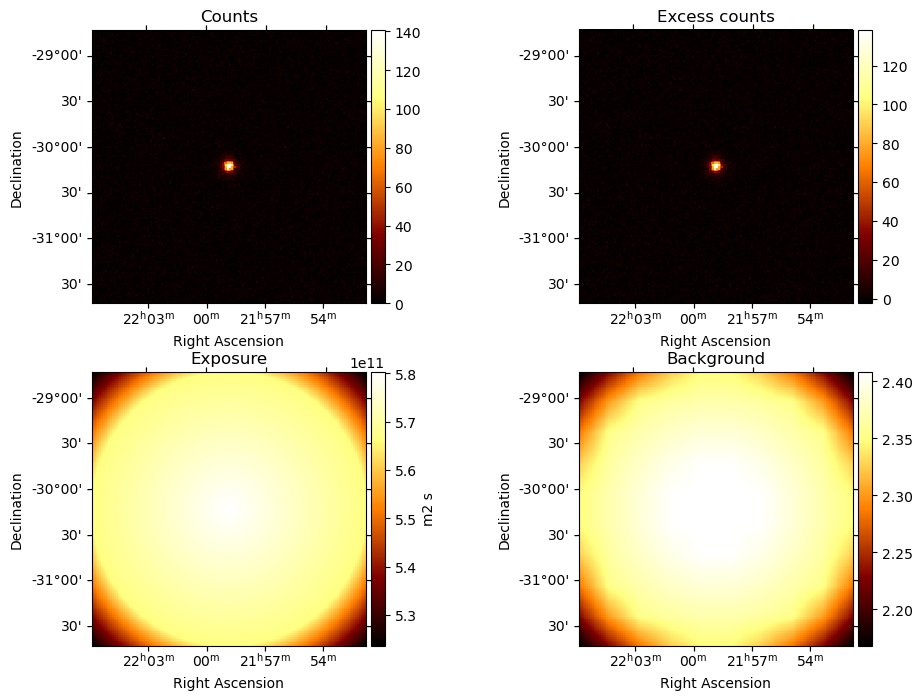

In [214]:
cta_dataset.peek()

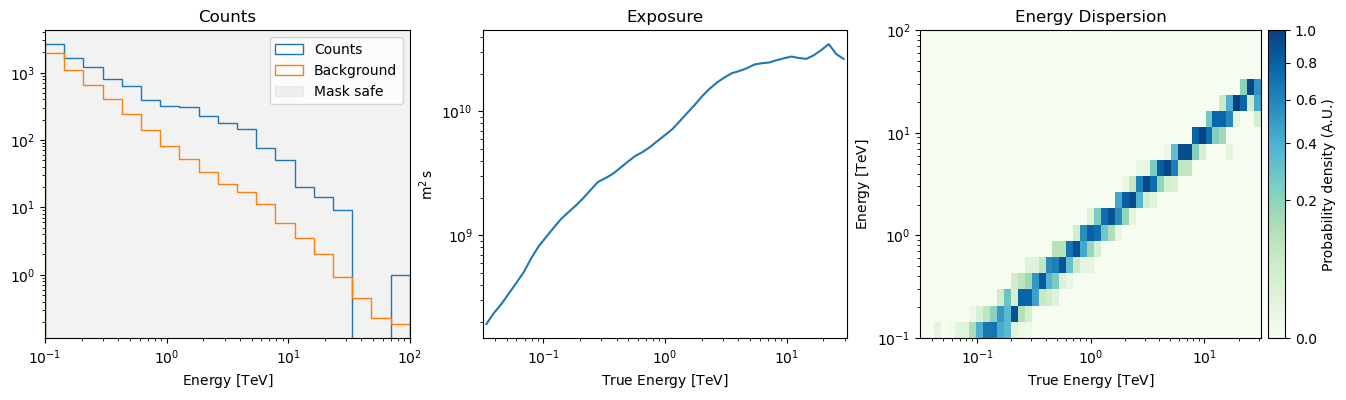

In [215]:
src_pos = SkyCoord.from_name("PKS 2155-304")
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
spectrum_dataset = cta_dataset.to_spectrum_dataset(on_region=region)
spectrum_dataset.peek()



In [238]:
models = Models()
## Background only
bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)
cta_dataset.models = models


In [239]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[cta_dataset])

CPU times: user 107 ms, sys: 4.07 ms, total: 111 ms
Wall time: 110 ms


In [240]:
result

In [241]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str15,str1,str9,float64,str3,float64,float64,float64,bool,bool,str1,str1
cta-dataset-bkg,,norm,1.0770e+00,,4.506e-03,nan,nan,False,True,,
cta-dataset-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
cta-dataset-bkg,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,


In [242]:
L0 = result.total_stat

In [243]:
spectral_model = ExpCutoffPowerLawSpectralModel()
spatial_model = PointSpatialModel()
pks_model = SkyModel(spectral_model=spectral_model,
                     spatial_model=spatial_model, 
                    name="pks_model")

In [244]:
spectral_model.amplitude.value = 1e-12
spectral_model.index.value = 2.0
spectral_model.lambda_.value = 0.0
spectral_model.lambda_.frozen = True # Behaves as a power law, cutoff fixed at infty

spatial_model.lon_0.value = src_pos.ra.value
spatial_model.lat_0.value = src_pos.dec.value

spatial_model.lon_0.min = src_pos.ra.value - 0.5
spatial_model.lon_0.max = src_pos.ra.value + 0.5

spatial_model.lat_0.min = src_pos.dec.value - 0.5
spatial_model.lat_0.max = src_pos.dec.value + 0.5

In [245]:
models = Models([pks_model, bkg_model])

In [246]:
cta_dataset.models = models


In [247]:
%%time
fit1 = Fit(optimize_opts={"print_level": 1})
result1 = fit1.run(datasets=[cta_dataset])


CPU times: user 7.49 s, sys: 328 ms, total: 7.82 s
Wall time: 7.86 s


In [248]:
result1

In [249]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str15,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
pks_model,,index,2.3448e+00,,1.381e-02,nan,nan,False,False,,
pks_model,,amplitude,1.0331e-11,TeV-1 s-1 cm-2,1.949e-13,nan,nan,False,True,,
pks_model,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
pks_model,,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,False,,
pks_model,,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,
pks_model,,lon_0,3.2972e+02,deg,8.635e-04,3.292e+02,3.302e+02,False,False,,
pks_model,,lat_0,-3.0226e+01,deg,7.675e-04,-3.073e+01,-2.973e+01,False,False,,
cta-dataset-bkg,,norm,1.0004e+00,,4.365e-03,nan,nan,False,True,,
cta-dataset-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,


In [250]:
L1 = result1.total_stat
print("del TS of detection: ", (L0-L1), )

del TS of detection:  20325.62826809258


In [251]:
energy_edges = cta_dataset.geoms["geom"].axes["energy"].edges
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name, selection_optional=["ul"], 
                          n_sigma_ul=2,
                         n_jobs=3)



In [252]:
flux_points1 = fpe.run(datasets=[cta_dataset])


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

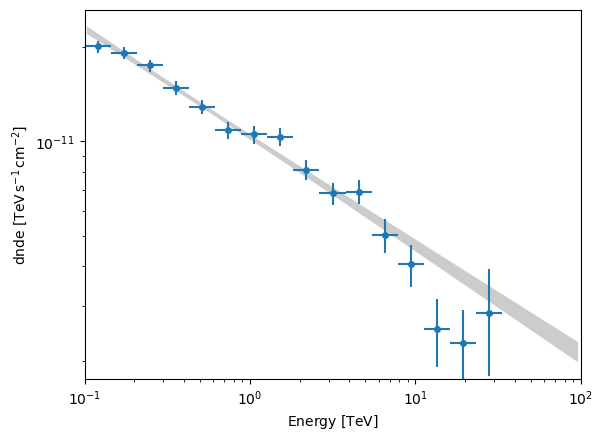

In [254]:
ax = spectral_model.plot_error(energy_bounds=[0.1,100]*u.TeV, energy_power=2)
flux_points1.plot(ax=ax, energy_power=2)

In [255]:
spectral_model.lambda_.frozen = False

In [256]:
%%time
fit3 = Fit(optimize_opts={"print_level": 1})
result3 = fit3.run(datasets=[cta_dataset])


CPU times: user 2.3 s, sys: 43 µs, total: 2.3 s
Wall time: 2.3 s


In [257]:


models.to_parameters_table()



model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str15,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
pks_model,,index,2.2898e+00,,2.202e-02,nan,nan,False,False,,
pks_model,,amplitude,1.1171e-11,TeV-1 s-1 cm-2,3.425e-13,nan,nan,False,True,,
pks_model,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
pks_model,,lambda_,3.3542e-02,TeV-1,1.083e-02,nan,nan,False,False,,
pks_model,,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,
pks_model,,lon_0,3.2972e+02,deg,8.638e-04,3.292e+02,3.302e+02,False,False,,
pks_model,,lat_0,-3.0226e+01,deg,7.688e-04,-3.073e+01,-2.973e+01,False,False,,
cta-dataset-bkg,,norm,1.0006e+00,,4.366e-03,nan,nan,False,True,,
cta-dataset-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,


In [258]:
L2 = result3.total_stat
print("del TS of cutoff: ",(L1-L2), "p-value: ", chi2.sf((L1-L2),1))

del TS of cutoff:  10.4696405386494 p-value:  0.0012135232875527232


CPU times: user 537 ms, sys: 0 ns, total: 537 ms
Wall time: 539 ms


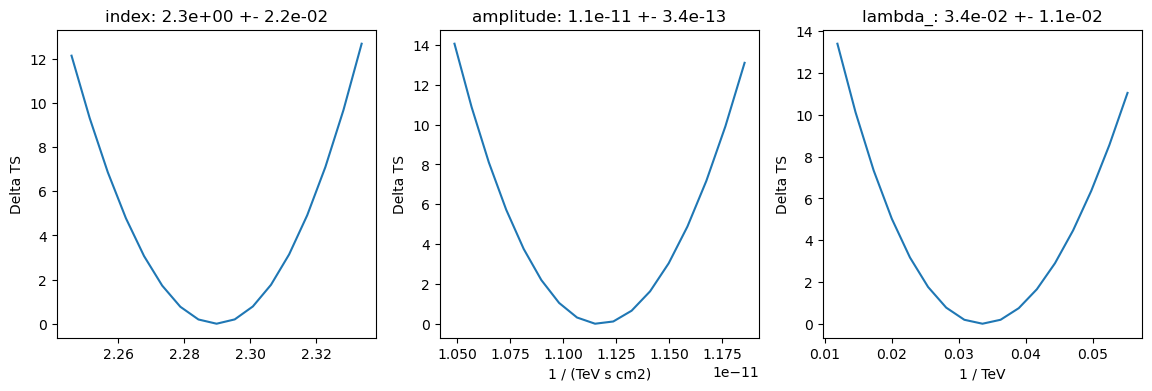

In [259]:
%%time
### See a likelihood scan of free parameters
total_stat = result3.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model.spectral_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit3.stat_profile(datasets=[cta_dataset], parameter=par, reoptimize=False)
    ax.plot(profile[f"{pks_model.name}.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")


Flux points

In [260]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

CPU times: user 275 ms, sys: 317 ms, total: 591 ms
Wall time: 5.9 s


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

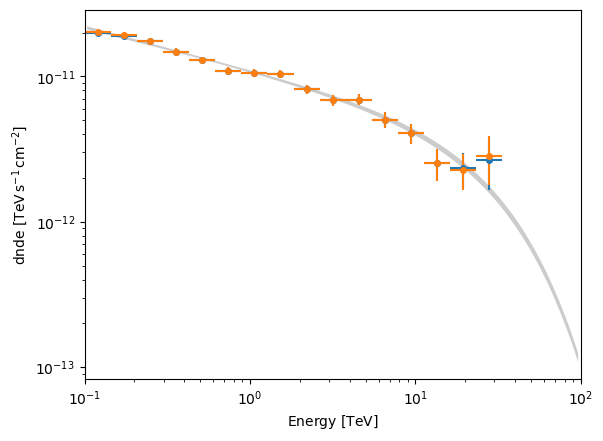

In [269]:
sed_type="e2dnde"
ax = spectral_model.plot_error(energy_bounds=[0.1,100]*u.TeV, sed_type=sed_type)
flux_points.plot(ax=ax, sed_type=sed_type)
flux_points1.plot(ax=ax, sed_type=sed_type)

## Using the inbuilt gammapy function

In [267]:
from gammapy.modeling.selection import select_nested_models
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling.models import SkyModel


result = select_nested_models(cta_dataset,
                              parameters=[pks_model.spectral_model.lambda_],
                              null_values=[0],
                              )

In [268]:
result

{'ts': 10.469732351979474,
 'fit_results': <gammapy.modeling.fit.FitResult at 0x7612b5dd6380>,
 'fit_results_null': <gammapy.modeling.fit.FitResult at 0x7611e4b82440>}

## With systematics in background model

- Assuming a 10% systematic uncertainty in each bin

## With systematics in energy dispersion

Refer to: https://github.com/bkhelifi/Brazil_2024/blob/main/Crab_simulations_systematic_errors_Solution.ipynb